# Task 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd

# Load X_train as a DataFrame
x_train_path = r"C:\Users\anshu\UCI HAR Dataset\train\X_train.txt"
X_train = pd.read_csv(x_train_path, delim_whitespace=True, header=None)

# Load y_train and convert it to a Series
y_train_path = r"C:\Users\anshu\UCI HAR Dataset\train\y_train.txt"
y_train = pd.read_csv(y_train_path, header=None).squeeze()  # Squeeze the DataFrame to a Series

# Load X_test as a DataFrame
x_test_path = r"C:\Users\anshu\UCI HAR Dataset\test\X_test.txt"
X_test = pd.read_csv(x_test_path, delim_whitespace=True, header=None)

# Load y_test and convert it to a Series
y_test_path = r"C:\Users\anshu\UCI HAR Dataset\test\y_test.txt"
y_test = pd.read_csv(y_test_path, header=None).squeeze()  # Squeeze the DataFrame to a Series

# Load subject_train as a Series
subject_train_path = r"C:\Users\anshu\UCI HAR Dataset\train\subject_train.txt"
subject_train = pd.read_csv(subject_train_path, header=None).squeeze()  # Squeeze the DataFrame to a Series

In [24]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(X_train_scaled).corr()

# Find highly correlated features (threshold > 0.90)
correlated_features = set()
threshold = 0.9

for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(i)  # Add the feature index to the set

# Create a reduced feature set by removing correlated features
X_train_reduced = np.delete(X_train_scaled, list(correlated_features), axis=1)
X_test_reduced = np.delete(X_test_scaled, list(correlated_features), axis=1)

print(f"Original feature set size: {X_train_scaled.shape[1]}")
print(f"Reduced feature set size: {X_train_reduced.shape[1]}")


Original feature set size: 561
Reduced feature set size: 202


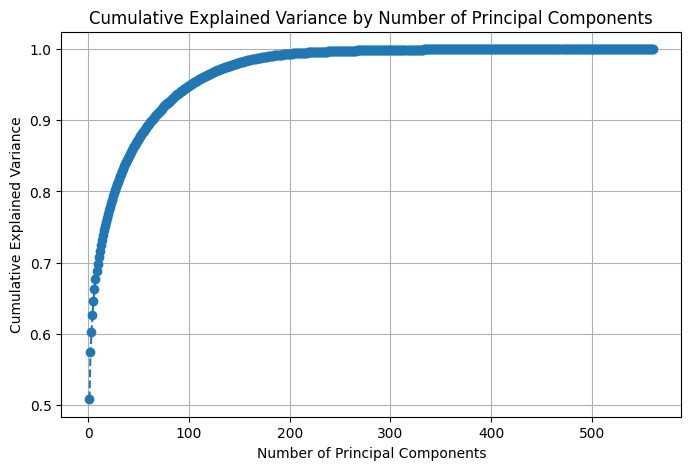

Principal Component 1: 50.78% explained variance
Principal Component 2: 6.58% explained variance
Principal Component 3: 2.81% explained variance
Principal Component 4: 2.50% explained variance
Principal Component 5: 1.89% explained variance
Principal Component 6: 1.72% explained variance
Principal Component 7: 1.37% explained variance
Principal Component 8: 1.20% explained variance
Principal Component 9: 1.00% explained variance
Principal Component 10: 0.97% explained variance
Principal Component 11: 0.86% explained variance
Principal Component 12: 0.80% explained variance
Principal Component 13: 0.76% explained variance
Principal Component 14: 0.65% explained variance
Principal Component 15: 0.63% explained variance
Principal Component 16: 0.60% explained variance
Principal Component 17: 0.59% explained variance
Principal Component 18: 0.58% explained variance
Principal Component 19: 0.57% explained variance
Principal Component 20: 0.53% explained variance
Principal Component 21: 0.50

In [27]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Apply PCA without specifying n_components to calculate explained variance for all components
pca = PCA()
X_train_pca_full = pca.fit_transform(X_train_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Display percentage of variance explained by each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i+1}: {ratio*100:.2f}% explained variance")

# Determine the number of components to retain 95% variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"\nNumber of components to retain 95% variance: {n_components_95}")


In [28]:
from sklearn.decomposition import PCA

# Apply PCA (retain 95% of variance)
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature set size: {X_train_scaled.shape[1]}")
print(f"PCA-reduced feature set size: {X_train_pca.shape[1]}")


Original feature set size: 561
PCA-reduced feature set size: 63


I will consider these 63 transformed features as they account to 90% of the information retained

## K fold Cross Validation

### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm  # Optional, for progress bar


# Define the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)

# K-Fold Cross-Validation setup (e.g., 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics (accuracy, precision, recall, F1 score)
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted'),
    "Recall": make_scorer(recall_score, average='weighted'),
    "F1 Score": make_scorer(f1_score, average='weighted')
}

# Create a dictionary to store the results
results = {metric: [] for metric in scoring.keys()}

# Use tqdm for progress tracking
for metric_name, metric in tqdm(scoring.items(), desc="Evaluating Decision Tree"):
    # Cross-validate using the current metric
    scores = cross_val_score(model, X_train_pca, y_train, cv=kf, scoring=metric)
    # Store the average score
    results[metric_name] = np.mean(scores)

# Display the results
print("\nDecision Tree Classifier Results:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")


Evaluating Decision Tree: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


Decision Tree Classifier Results:
Accuracy: 0.8236
Precision: 0.8244
Recall: 0.8236
F1 Score: 0.8237


### Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)

# K-Fold Cross-Validation setup (e.g., 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics (accuracy, precision, recall, F1 score)
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted'),
    "Recall": make_scorer(recall_score, average='weighted'),
    "F1 Score": make_scorer(f1_score, average='weighted')
}

# Create a dictionary to store the results
results = {metric: [] for metric in scoring.keys()}

# Use tqdm for progress tracking
for metric_name, metric in tqdm(scoring.items(), desc="Evaluating Random Forest"):
    # Cross-validate using the current metric
    scores = cross_val_score(model, X_train_pca, y_train, cv=kf, scoring=metric)
    # Store the average score
    results[metric_name] = np.mean(scores)

# Display the results
print("\nRandom Forest Classifier Results:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")


Evaluating Random Forest: 100%|██████████| 4/4 [00:33<00:00,  8.33s/it]


Random Forest Classifier Results:
Accuracy: 0.9308
Precision: 0.9318
Recall: 0.9308
F1 Score: 0.9304


### Adaboost

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Use a deeper base decision tree
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=42)

# Define the AdaBoost classifier with the deeper base estimator and adjusted learning rate
model = AdaBoostClassifier(estimator=base_estimator, random_state=42, learning_rate=0.5, n_estimators=50)

# K-Fold Cross-Validation setup (e.g., 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics (accuracy, precision, recall, F1 score)
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted', zero_division=1),
    "Recall": make_scorer(recall_score, average='weighted'),
    "F1 Score": make_scorer(f1_score, average='weighted')
}

# Create a dictionary to store the results
results = {metric: [] for metric in scoring.keys()}

# Use tqdm for progress tracking
for metric_name, metric in tqdm(scoring.items(), desc="Evaluating AdaBoost"):
    # Cross-validate using the current metric
    scores = cross_val_score(model, X_train_pca, y_train, cv=kf, scoring=metric)
    # Store the average score
    results[metric_name] = np.mean(scores)

# Display the results
print("\nAdaBoost Classifier Results:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")


Evaluating AdaBoost:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warning


AdaBoost Classifier Results:
Accuracy: 0.8005
Precision: 0.8160
Recall: 0.8005
F1 Score: 0.8014


### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Define the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

# K-Fold Cross-Validation setup (e.g., 5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics (accuracy, precision, recall, F1 score)
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted', zero_division=1),
    "Recall": make_scorer(recall_score, average='weighted'),
    "F1 Score": make_scorer(f1_score, average='weighted')
}

# Create a dictionary to store the results
results = {metric: [] for metric in scoring.keys()}

# Use tqdm for progress tracking
for metric_name, metric in tqdm(scoring.items(), desc="Evaluating Logistic Regression"):
    # Cross-validate using the current metric
    scores = cross_val_score(model, X_train_pca, y_train, cv=kf, scoring=metric)
    # Store the average score
    results[metric_name] = np.mean(scores)

# Display the results
print("\nLogistic Regression Classifier Results:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")



Evaluating Logistic Regression:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org


Logistic Regression Classifier Results:
Accuracy: 0.9567
Precision: 0.9568
Recall: 0.9567
F1 Score: 0.9567


Summary of ML models trained on reduced dataset using K fold cross validation:

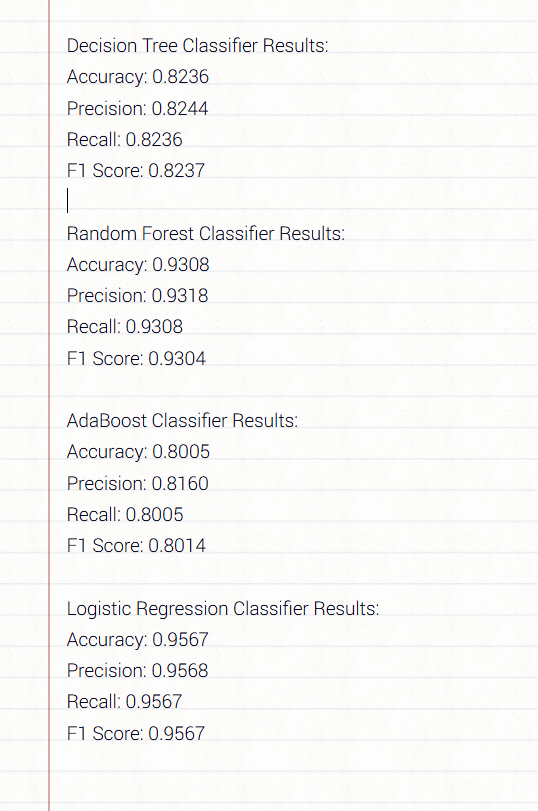

## Leave One Subject Out Cross Validation

### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Ensure you load the subject_train array
subject_train_path = r"C:\Users\anshu\UCI HAR Dataset\train\subject_train.txt"
subject_train = pd.read_csv(subject_train_path, header=None).squeeze()

# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Initialize Leave-One-Subject-Out Cross-Validation
logo = LeaveOneGroupOut()

# Create a dictionary to store the results
results = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Use tqdm for progress tracking
for metric_name in tqdm(results.keys(), desc="Evaluating Decision Tree (LOSO-CV)"):
    # Initialize list to store scores for each fold
    fold_scores = []
    
    # Perform Leave-One-Subject-Out Cross-Validation
    for train_idx, test_idx in logo.split(X_train_pca, y_train, groups=subject_train):
        # Split the PCA-transformed data based on subject index
        X_train_cv, X_test_cv = X_train_pca[train_idx], X_train_pca[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Predict on the test set
        y_pred = model.predict(X_test_cv)
        
        # Calculate the chosen metric
        if metric_name == "Accuracy":
            score = accuracy_score(y_test_cv, y_pred)
        elif metric_name == "Precision":
            score = precision_score(y_test_cv, y_pred, average='weighted', zero_division=1)
        elif metric_name == "Recall":
            score = recall_score(y_test_cv, y_pred, average='weighted')
        elif metric_name == "F1 Score":
            score = f1_score(y_test_cv, y_pred, average='weighted')
        
        fold_scores.append(score)
    
    # Store the average score across all folds
    results[metric_name] = np.mean(fold_scores)

# Display the results
print("\nDecision Tree (LOSO-CV) Classifier Results with PCA:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")


Evaluating Decision Tree (LOSO-CV): 100%|██████████| 4/4 [00:52<00:00, 13.11s/it]


Decision Tree (LOSO-CV) Classifier Results with PCA:
Accuracy: 0.7347
Precision: 0.7536
Recall: 0.7347
F1 Score: 0.7302


### Random Forest

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Ensure you load the subject_train array
subject_train_path = r"C:\Users\anshu\UCI HAR Dataset\train\subject_train.txt"

# Initialize the Decision Tree model
model = RandomForestClassifier(n_jobs=-1, random_state=42)

# Initialize Leave-One-Subject-Out Cross-Validation
logo = LeaveOneGroupOut()

# Create a dictionary to store the results
results = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Use tqdm for progress tracking
for metric_name in tqdm(results.keys(), desc="Evaluating Decision Tree (LOSO-CV)"):
    # Initialize list to store scores for each fold
    fold_scores = []
    
    # Perform Leave-One-Subject-Out Cross-Validation
    for train_idx, test_idx in logo.split(X_train_pca, y_train, groups=subject_train):
        # Split the PCA-transformed data based on subject index
        X_train_cv, X_test_cv = X_train_pca[train_idx], X_train_pca[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Predict on the test set
        y_pred = model.predict(X_test_cv)
        
        # Calculate the chosen metric
        if metric_name == "Accuracy":
            score = accuracy_score(y_test_cv, y_pred)
        elif metric_name == "Precision":
            score = precision_score(y_test_cv, y_pred, average='weighted', zero_division=1)
        elif metric_name == "Recall":
            score = recall_score(y_test_cv, y_pred, average='weighted')
        elif metric_name == "F1 Score":
            score = f1_score(y_test_cv, y_pred, average='weighted')
        
        fold_scores.append(score)
    
    # Store the average score across all folds
    results[metric_name] = np.mean(fold_scores)

# Display the results
print("\nRandom Forest (LOSO-CV) Classifier Results with PCA:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")



Random Forest (LOSO-CV) Classifier Results with PCA:
Accuracy: 0.8596
Precision: 0.8932
Recall: 0.8596
F1 Score: 0.8520


### Adaboost

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Ensure you load the subject_train array
subject_train_path = r"C:\Users\anshu\UCI HAR Dataset\train\subject_train.txt"



base_estimator = DecisionTreeClassifier(max_depth=2, random_state=42)
model = AdaBoostClassifier(estimator=base_estimator, random_state=42, learning_rate=0.2, n_estimators=50)

# Initialize Leave-One-Subject-Out Cross-Validation
logo = LeaveOneGroupOut()

# Create a dictionary to store the results
results = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Use tqdm for progress tracking
for metric_name in tqdm(results.keys(), desc="Evaluating Decision Tree (LOSO-CV)"):
    # Initialize list to store scores for each fold
    fold_scores = []
    
    # Perform Leave-One-Subject-Out Cross-Validation
    for train_idx, test_idx in logo.split(X_train_pca, y_train, groups=subject_train):
        # Split the PCA-transformed data based on subject index
        X_train_cv, X_test_cv = X_train_pca[train_idx], X_train_pca[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Predict on the test set
        y_pred = model.predict(X_test_cv)
        
        # Calculate the chosen metric
        if metric_name == "Accuracy":
            score = accuracy_score(y_test_cv, y_pred)
        elif metric_name == "Precision":
            score = precision_score(y_test_cv, y_pred, average='weighted', zero_division=1)
        elif metric_name == "Recall":
            score = recall_score(y_test_cv, y_pred, average='weighted')
        elif metric_name == "F1 Score":
            score = f1_score(y_test_cv, y_pred, average='weighted')
        
        fold_scores.append(score)
    
    # Store the average score across all folds
    results[metric_name] = np.mean(fold_scores)

# Display the results
print("\nAdaboost Classifier (LOSO-CV) Classifier Results with PCA:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")


Evaluating Decision Tree (LOSO-CV):   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in


Adaboost Classifier (LOSO-CV) Classifier Results with PCA:
Accuracy: 0.6856
Precision: 0.7609
Recall: 0.6856
F1 Score: 0.6603


### Logistic

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Ensure you load the subject_train array
subject_train_path = r"C:\Users\anshu\UCI HAR Dataset\train\subject_train.txt"



# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
# Initialize Leave-One-Subject-Out Cross-Validation
logo = LeaveOneGroupOut()

# Create a dictionary to store the results
results = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Use tqdm for progress tracking
for metric_name in tqdm(results.keys(), desc="Evaluating Decision Tree (LOSO-CV)"):
    # Initialize list to store scores for each fold
    fold_scores = []
    
    # Perform Leave-One-Subject-Out Cross-Validation
    for train_idx, test_idx in logo.split(X_train_pca, y_train, groups=subject_train):
        # Split the PCA-transformed data based on subject index
        X_train_cv, X_test_cv = X_train_pca[train_idx], X_train_pca[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Predict on the test set
        y_pred = model.predict(X_test_cv)
        
        # Calculate the chosen metric
        if metric_name == "Accuracy":
            score = accuracy_score(y_test_cv, y_pred)
        elif metric_name == "Precision":
            score = precision_score(y_test_cv, y_pred, average='weighted', zero_division=1)
        elif metric_name == "Recall":
            score = recall_score(y_test_cv, y_pred, average='weighted')
        elif metric_name == "F1 Score":
            score = f1_score(y_test_cv, y_pred, average='weighted')
        
        fold_scores.append(score)
    
    # Store the average score across all folds
    results[metric_name] = np.mean(fold_scores)

# Display the results
print("\nLogistic Regression (LOSO-CV) Classifier Results with PCA:")
for metric_name, value in results.items():
    print(f"{metric_name}: {value:.4f}")


Evaluating Decision Tree (LOSO-CV):   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn


Logistic Regression (LOSO-CV) Classifier Results with PCA:
Accuracy: 0.9040
Precision: 0.9269
Recall: 0.9040
F1 Score: 0.8991


Summary of ML models trained on reduced dataset using Leave one Subject out Cross Validation:

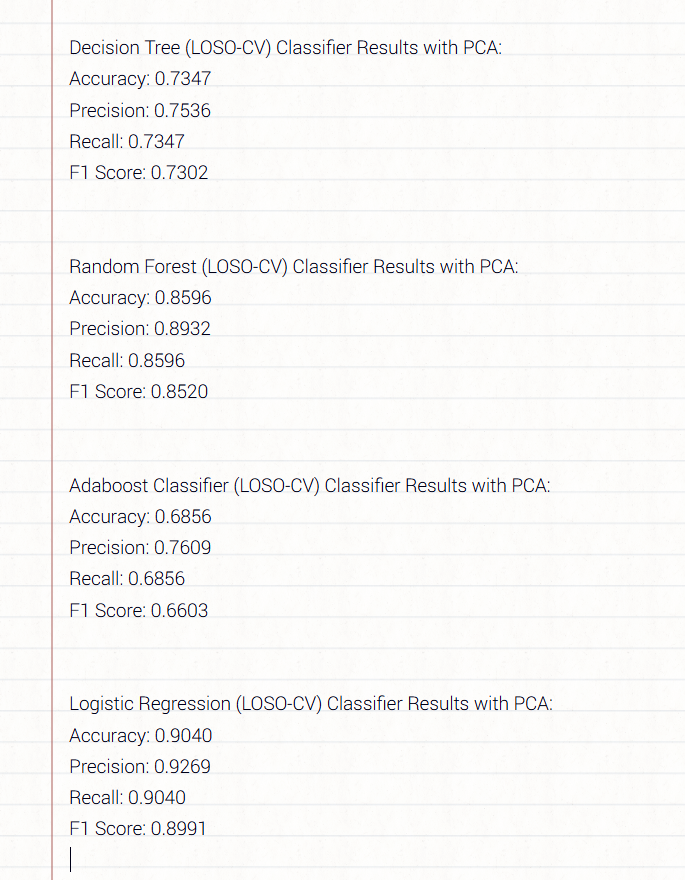